# Code Review III - Multivariate Distributions

Now, the moment we've all be waiting for: How do these methods perform on multivariate distributions. So for this code review, I'll be walking through how these methods compare and I will try to have some telling plots where we outline exactly how each method performs when estimating multivariate distributions such as the Gaussian and T-Student.

#### Recap

So far we've seen how we can estimate sigma as well as how we can estimate the HSIC value. We've seen that this HSIC value depends on the sigma estimator method as well as how we configure the sigma parameter (per dataset, per dimension). So we have a set of methods, now we just need to see how these methods perform when we change the number of dimensions as well as the amount of samples.

In [111]:
import sys, os

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# Insert path to package,.
pysim_path = f"/home/emmanuel/code/pysim/"
sys.path.insert(0, pysim_path)

import warnings
from typing import Optional, Tuple
from tqdm import tqdm
import random
import pandas as pd
import numpy as np
import argparse
from sklearn.utils import check_random_state

# toy datasets
from data.distribution import DataParams, Inputs

# Kernel Dependency measure
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF
from models.dependence import HSICModel

# RBIG IT measures
# from models.ite_algorithms import run_rbig_models

# Plotting
from visualization.distribution import plot_scorer

# experiment helpers
from experiments.utils import dict_product, run_parallel_step
from tqdm import tqdm

# Plotting Procedures
import matplotlib
sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7, rc={'font.family': 'sans-serif'})
# sns.set(font='sans-serif')
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
!pwd

/home/emmanuel/projects/2019_hsic_align/notebooks/4_distributions


In [63]:
FIG_PATH = "/home/emmanuel/projects/2019_hsic_align/results/figures/distribution_experiment/mutual_info/"
RES_PATH = "/home/emmanuel/projects/2019_hsic_align/data/results/distributions/mutual_info/"

### Experimental Parameters

In [64]:
# initialize the holder for the parameters
parameters = {}

#### Case I - HSIC Estimator

In this first part, we have 3 cases of HSIC as a combination of a centered kernel and whether or not we normalize the covariance term. The 3 "scorers" are as follows:


1. **HSIC**

$$HSIC = \frac{1}{n(n-1)}\langle K_xH,K_yH \rangle_F$$

> In this case, the kernels are **centered**, but the score is **not normalized**.


2. **Kernel Alignment** (KA) 

$$TKA = \frac{\langle K_x,K_y \rangle_F}{||K_x||_F||K_y||_F}$$

> In this case, the kernels are **not centered** but the score is **normalized**.

3. **cTKA**

$$cTKA = \frac{\langle K_xH,K_yH \rangle_F}{||K_xH||_F||K_yH||_F}$$

> In this case, the kernels are **centered** and the score is **normalized**.

In [65]:
# def get_hsic(
#     X: np.ndarray, 
#     Y: np.ndarray, 
#     scorer: str, 
#     sigma_X: Optional[float]=None, 
#     sigma_Y: Optional[float]=None
# ) -> float:
#     """Estimates the HSIC value given some data, sigma and
#     the score."""
#     # init hsic model class
    
#     hsic_model = HSICModel()
#     # hsic model params
#     if sigma_X is not None:
        
#         hsic_model.kernel_X = RBF(sigma_X)
#         hsic_model.kernel_Y = RBF(sigma_Y)

#     # get hsic score
#     hsic_val = hsic_model.get_score(X, Y, scorer)
    
#     return hsic_val

# parameters
parameters['scorer'] = ['hsic', 'ka', 'cka'] 

#### Case II - Sigma Estimator

For this parameter, we are interested in estimating a few things:

1. We want to know which estimator to choose from.

Kernel methods are great if the parameters of the kernel are correct. In supervised scenarios, we can simply learn the appropriate kernel parameters that best fit our data given some criteria. In unsupervised settings, we generally do not know which parameters to choose from. But there are many different ways to choose the parameters as every lab/researcher has their own method that "they swear by". I will choose some of the most common ones: 

* Silverman
* Scott
* Mean Distance
* Median Distance
* Median Distance with the $k^{th}$ sample (or percent) of that distance matrix.

#### Case III - Sigma Application

2. We want to know the how we are applying the length scale.

We have three cases to consider:

* One length scale for both datasets
* One length scale per dataset
* One length scale per dataset per dimension

This is important as it could turn a good estimator into a bad estimator. Scott and Silverman work very well for univariate distributions but not very well for multivariate distributions. So if we have one scott/silverman estimate per feature, then this estimator might be a lot better and yield much better results. For the case of the RBF kernel, having one length scale per dimension corresponds to the ARD Kernel which assigns a length scale (or relevance values) per feature. We don't typically use the ARD kernel for kernel methods that we cannot optimize using some gradient function due to how expensive it is. But in this case, it isn't so expensive because we are choosing not to optimizing anything.

In [66]:
from typing import Optional
from scipy.spatial.distance import pdist, squareform
from models.dependence import HSICModel

def scotts_factor(X: np.ndarray) -> float:
    """Scotts Method to estimate the length scale of the 
    rbf kernel.
    
        factor = n**(-1./(d+4))
    
    Parameters
    ----------
    X : np.ndarry
        Input array
    
    Returns
    -------
    factor : float
        the length scale estimated
    
    """
    n_samples, n_features = X.shape
    
    return np.power(n_samples, - 1 / (n_features + 4.))

def silvermans_factor(X: np.ndarray) -> float:
    """Silvermans method used to estimate the length scale
    of the rbf kernel.
    
    factor = (n * (d + 2) / 4.)**(-1. / (d + 4)).
    
    Parameters
    ----------
    X : np.ndarray,
        Input array
    
    Returns
    -------
    factor : float
        the length scale estimated
    """
    n_samples, n_features = X.shape
    
    base = ( n_samples * (n_features + 2.) ) / 4.
    
    return np.power(base, - 1 / (n_features + 4.))




def kth_distance(dists: np.ndarray, percent: float) -> np.ndarray:
    
    # kth distance calculation (50%)
    kth_sample = int(percent * dists.shape[0])
    
    # take the Kth neighbours of that distance
    k_dist = dists[:, kth_sample]
    
    return k_dist

def sigma_estimate(
    X: np.ndarray, 
    method: str='median', 
    percent: Optional[int]=None, 
    heuristic: bool=False
) -> float:
    
    # get the squared euclidean distances
    if method == 'silverman':
        return silvermans_factor(X)
    elif method == 'scott':
        return scotts_factor(X)
    elif percent is not None:
        kth_sample = int((percent/100) * X.shape[0])
        dists = np.sort(squareform(pdist(X, 'sqeuclidean')))[:, kth_sample]
#         print(dists.shape, dists.min(), dists.max())
    else:
        dists = np.sort(pdist(X, 'sqeuclidean'))
#         print(dists.shape, dists.min(), dists.max())
        
    
    if method == 'median':
        sigma = np.median(dists)
    elif method == 'mean':
        sigma = np.mean(dists)
    else:
        raise ValueError(f"Unrecognized distance measure: {method}")
    
    if heuristic:
        sigma = np.sqrt(sigma / 2)
    return sigma



In [67]:
# Parameters for the estimators
parameters['sigma_estimator'] = [
        ('median', 15),
        ('median', 20),
        ('median', 50),
        ('median', 80),
        ('scott',None),
        ('silverman',None),
        ('median', None),
]
parameters['separate_scales'] = [True]
parameters['per_dimension'] = [True, False]

#### Case IV - Standardize or not Standardize

This is a simple case but it can have drastic changes in the results of estimating the length scale. In ML, we tend to standardize our datasets because the algorithms do better with predictions with the ranges are contained. Datasets with massive values for certain features could have adverse affects on the representation and the predictions. The formula is given by:

$$\bar{x} = \frac{x - \mu_x}{\sigma_x}$$

**Note**: this is scaling per feature and not per sample. 

In [68]:
# from typing import Tuple, Optional

def standardize_data(
    X: np.ndarray, 
    Y: np.ndarray, 
    standardize: bool=False
) -> Tuple[np.ndarray, np.ndarray]:
    X = StandardScaler().fit_transform(X)
    Y = StandardScaler().fit_transform(Y)
    return X, Y

# experimental parameters
parameters['standardize'] = [True, False]

### Case V - Multivariate Datasets

For this experiment, we have generated samples for two sets of multivariate distributions: the Gaussian and the T-Student. We have varied the parameters so that we get a variety of samples, dimensions and the amount of similarity (that we can analytically calculate) between them. 

For example, we can take a Gaussian distribution with a covariance and generate a similar Gaussian distribution with the same number of samples and variance with a covariance. We know the cross-covariance between them and the self-covariances, so we can analytically calculate the mutual information between the two. MI is absolute which is the dependence or similarity between the two datasets. Now, we will see how the HSIC scores will do versus this variation of dataset size and shape. 

We have the following parameters:


| Parameter | Entry |
| :---:| :---:|
| Samples | 50, 100, 500, 1K, 5K |
| Dimensions | 2, 3, 10, 50, 100 |
| Trials | 1 $\rightarrow$ 5 |
| Distributions | Gaussian, T-Student |
| std (Gauss dist) | 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 |
| nu (T-Stu dist) | 1, 2, 3, 4, 5, 6, 7, 8, 9 |

In [27]:
# example parameters for the dataset
parameters['dataset'] = ['gauss'] 
parameters['std'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 
parameters['nu'] = [1]
parameters['trial'] = [1, 2, 3, 4, 5]
parameters['dimensions'] = [2, 3, 10, 50, 100]

# Loop Params
loop_params = {}
loop_params["samples"] = [50, 100, 500, 1_000, 5_000]

# example parameters function
example_params = DataParams()

# generates a named tuple containing the inputs and the MI 
inputs = example_params.generate_data()

#### Main Loop (**Update**)

So it turns out just doing a blind parallel scheme ended up taking too much time. So I decided to break the problem up a bit. 

1. Do 1 Main Loop (Samples)

I decided not to combine all of the combinations; I did all except for the number of samples. Everytime I was watching the progress bar, it would slow down every once in a while. That was because the bottleneck for kernel methods is the number of samples. We have cases of 1_000 which isn't too bad, but 5_000 samples is where the methods really start to slow down. In addition, there will be a lot of memory consumption. So I decided to do a main loop through the number of samples (starting from the smallest and ending with the largest). That way, we can get the easier datasets out of the way and then work on the larger datasets later.

2. Controlling the number of jobs.

As I mentioned before, the bottleneck is the number of samples. With 5_000, this starts to eat up a lot of memory when doing this in parallel. So to prevent this I set it up such that I control the number of cores doing the processing. Like so:

| # Samples | Cores |
| :---:| :---:|
| 50 | 28 |
| 100 | 28 |
| 500 | 28 |
| 1_000 | 16 |
| 5_000 | 8 |


3. Appending Data

Because there was a lot of data being shifted around ($\sim 297000$ parameters), the resulting `dataframe` which stores the experimental results is going to be huge. So I decided that for every call to the main loop, I will run append those results to a csv file and then del that dataframe to free up memory.

## Experiment

We have a lot of parameters. So we are going to run everything in parallel so that we can save time. We will do this by giving the cartesian product of our nD list of parameters. This will give us a list of tuples where each entry is a set of parameters to evaluate. The length of this list will be the total number of parameters.

In [28]:
# create a list of all param combinations
    # shuffle parameters
params = list(dict_product(parameters))
loop_params = list(dict_product(loop_params))
# parameters_list = list(dict_product(parameters))
n_params, n_loop_params = len(params), len(loop_params)
print('# of Params:', n_params, n_loop_params)

# of Params: 23100 5


In [34]:
from typing import Dict 

def step(
    params: Dict, loop_param: Dict,
):

    # ================
    # DATA
    # ================
    dist_data = DataParams(
        dataset=params["dataset"],
        trial=params["trial"],
        std=params["std"],
        nu=params["nu"],
        samples=loop_param["samples"],
        dimensions=params["dimensions"],
    )

    # generate data
    inputs = dist_data.generate_data()
    
    # ========================
    # Estimate Sigma
    # ========================
    f_x = lambda x: sigma_estimate(
        x, 
        method=params['sigma_estimator'][0], 
        percent=params['sigma_estimator'][1], 
        heuristic=False
    )

    # ========================
    # Per Dimension
    # ========================
    if params['per_dimension']:
        sigma_X = [f_x(ifeature.reshape(-1, 1)) for ifeature in inputs.X.T]
        sigma_Y = [f_x(ifeature.reshape(-1, 1)) for ifeature in inputs.Y.T]

    else:
        sigma_X = f_x(inputs.X)
        sigma_Y = f_x(inputs.Y)

    # =========================
    # Estimate HSIC
    # =========================
    hsic_clf = HSICModel(
        kernel_X=RBF(sigma_X),
        kernel_Y=RBF(sigma_Y),
    )
    
    score = hsic_clf.get_score(inputs.X, inputs.Y, params['scorer'])

    # ====================
    # Results
    # ====================

    # append results to dataframe
    results_df = pd.DataFrame(
        {
            # Data Params
            "dataset": [params["dataset"]],
            "trial": [params["trial"]],
            "std": [params["std"]],
            "nu": [params["nu"]],
            "samples": [loop_param["samples"]],
            "dimensions": [params["dimensions"]],
            # STANDARDIZE PARSM
            "standardize": [params["standardize"]],
            # SIGMA FORMAT PARAMS
            "per_dimension": [params["per_dimension"]],
            # SIGMA METHOD PARAMS
            "sigma_method": [params["sigma_estimator"][0]],
            "sigma_percent": [params["sigma_estimator"][1]],
            "sigma_X": [sigma_X],
            "sigma_Y": [sigma_Y],
            # HSIC Params
            "scorer": [params["scorer"]],
            "score": [score],
            "mutual_info": [inputs.mutual_info],
        }
    )
    return results_df

### Test - Single Step

In [35]:
results_df = run_parallel_step(
            exp_step=step,
            parameters=params,
            n_jobs=-1,
            verbose=1,
            loop_param=loop_params[0],
        )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 1194 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 2394 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 3144 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 3994 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 4944 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 6640 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 8940 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 11440 tasks      | elapsed:   47.6s


KeyboardInterrupt: 

In [36]:
results_df.tail()

NameError: name 'results_df' is not defined

In [43]:
# save results
save_name = "test"
dataset = 'gaussian'
header = True
mode = "w"
with open(f"{RES_PATH}{save_name}_{dataset}.csv", mode) as f:
    results_df.to_csv(f, header=header)

In [45]:
# get params
# params, loop_params = get_parameters(args.dataset, njobs=args.njobs)
save_name = "test"
dataset = 'gaussian'

# initialize datast
header = True
mode = "w"
with tqdm(loop_params) as pbar:
    for iparam in pbar:

        pbar.set_description(
            f"# Samples: {iparam['samples']}, Tasks: {len(params)}"
        )

        results_df = run_parallel_step(
            exp_step=step,
            parameters=params,
            n_jobs=-1,
            verbose=1,
            loop_param=iparam,
        )

        # concat current results
        results_df = pd.concat(results_df, ignore_index=True)

        # save results
        with open(f"{RES_PATH}{save_name}_{dataset}.csv", mode) as f:
            results_df.to_csv(f, header=header)

        header = False
        mode = "a"
        del results_df
        break

# Samples: 50, Tasks: 23100:   0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 732 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1432 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 4732 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 6232 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 7932 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 9832 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 11932 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 14232 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 16732 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 19432 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 22332 ta

In [12]:
step_df

,dataset,trial,std,nu,samples,dimensions,standardize,per_dimension,separate_scales,sigma_method,sigma_percent,sigma_X,sigma_Y,scorer,score,mutual_info
0,gauss,1,1,1,50,2,True,True,True,median,0.1,"[0.1686566316684468, 0.14612229488391992]","[0.1589719949193001, 0.1680410083908699]",hsic,0.019091,0.0


### Test - Full Loop

In [ ]:
# get params
# params, loop_params = get_parameters(args.dataset, njobs=args.njobs)
save_name = "test_full"
dataset = 'gaussian'

# initialize dataset
header = True
mode = "w"
with tqdm(loop_params) as pbar:
    for iparam in pbar:

        pbar.set_description(
            f"# Samples: {iparam['samples']}, Tasks: {len(params)}"
        )

        results_df = run_parallel_step(
            exp_step=step,
            parameters=params,
            n_jobs=-1,
            verbose=1,
            loop_param=iparam,
        )

        # concat current results
        results_df = pd.concat(results_df, ignore_index=True)

        # save results
        with open(f"{RES_PATH}{save_name}_{dataset}.csv", mode) as f:
            results_df.to_csv(f, header=header)

        header = False
        mode = "a"


# Samples: 50, Tasks: 23100:   0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 732 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1432 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 2332 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 3432 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 4732 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 6232 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 7932 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 9832 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 11932 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 14232 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 16732 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 19432 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 22332 ta

In [160]:
results_df = pd.read_csv(f"{RES_PATH}{save_name}_{dataset}.csv")

results_df = results_df.loc[:, ~results_df.columns.str.match('Unnamed')]

results_df = results_df.astype(object).replace(np.nan, 'None')

In [161]:
results_df.tail()

,dataset,trial,std,nu,samples,dimensions,standardize,per_dimension,sigma_method,sigma_percent,sigma_X,sigma_Y,scorer,score,mutual_info
115495,gauss,5,11,1,5000,2,False,False,median,None,2.596209486629066,2.533566551925972,cka,0.408078,0.390005
115496,gauss,5,11,1,5000,3,False,False,median,None,4.114994392992097,4.495821703399767,cka,0.453781,0.377389
115497,gauss,5,11,1,5000,10,False,False,median,None,14.882197509532734,15.57776152697343,cka,0.752609,0.929178
115498,gauss,5,11,1,5000,50,False,False,median,None,67.1011981827926,65.92873890142732,cka,0.969342,4.052644
115499,gauss,5,11,1,5000,100,False,False,median,None,129.70371717695562,129.7259155663332,cka,0.985882,7.938746


In [291]:
results_df.sigma_percent.unique().tolist()

[15.0, 20.0, 50.0, 80.0, 'None']

## Visualization

* Indiscrimenant Points - Dimensions, Samples
* Method - colors
* Standardize - type
* Correlation (MI, Score)

### Method I - Scott, Silverman

In [170]:
# segment scott
sub_df = results_df[results_df["sigma_method"] == 'silverman']
# sub_df = sub_df[sub_df["sigma_percent"] == 'None']

# dropcolumns with dimensions and samples
sub_df = sub_df.drop(['dimensions', 'samples', 'std', 'nu', 'trial', 'dataset', 'sigma_X', 'sigma_Y'], axis=1)



sub_df.tail()

,standardize,per_dimension,sigma_method,sigma_percent,scorer,score,mutual_info
114395,False,False,silverman,None,cka,0.044627,0.390005
114396,False,False,silverman,None,cka,0.065012,0.377389
114397,False,False,silverman,None,cka,0.966685,0.929178
114398,False,False,silverman,None,cka,1.000000,4.052644
114399,False,False,silverman,None,cka,1.000000,7.938746


### Convenience Functions

#### I - Subsetting the DataFrame

We want to be able to query the dataframe with multiple queries at a time. So I'll create a `namedtuple` which will hold the name of the column and the elements I want to access. Then I'll have a function that will take a list of these datastructures

In [236]:
from typing import List, Optional, Union

df_query = namedtuple('df_query', ['name', 'elements'])

def subset_dataframe(
    df: pd.DataFrame, 
    queries: List[df_query],
)-> pd.DataFrame:
    
    # copy dataframe to prevent overwriting
    sub_df = df.copy()
    
    #
    for iquery in queries:
        sub_df = sub_df[sub_df[iquery.name].isin(iquery.elements)]
    
    return sub_df

In [242]:
# subset dataframe
scorer = 'hsic'
hsic_data_df = subset_dataframe(results_df, [df_query('scorer', [scorer])])

hsic_data_df.head(2)

,dataset,trial,std,nu,samples,dimensions,standardize,per_dimension,sigma_method,sigma_percent,sigma_X,sigma_Y,scorer,score,mutual_info
0,gauss,1,1,1,50,2,True,True,median,15,"[0.05289913460722866, 0.046005156305852286]","[0.0603301351143148, 0.06549625956610451]",hsic,0.019532,0.0
1,gauss,1,1,1,50,3,True,True,median,15,"[0.05289913460722866, 0.046005156305852286, 0....","[0.06549625956610451, 0.05939212909166344, 0.0...",hsic,0.019590,0.0


In [243]:
# check
for iscorer in ['hsic', 'ka', 'cka']:
    # subset dataframe
    sub_df = subset_dataframe(results_df, [df_query('scorer', [iscorer])])
    
    # check that the only element is the one we query-ed
    assert sub_df.scorer.unique().tolist() == [iscorer]


#### II - Correlations

I want to see the correlations between the mutual information and the score. So I'll make a dedicated function to handle that. I'll use a `namedtuple` to ensure that the results are a callable datastructure and immutable (cannot be overwritten).

In [244]:
from scipy import stats
from collections import namedtuple

corr_stats = namedtuple('corr_stats', ['pearson', 'spearman'])

def get_correlations(df: pd.DataFrame):
    """Inputs a dataframe and outputs the correlation between
    the mutual information and the score.
    
    Requires the 'mutual_info' and 'score' columns."""
    
    # check that columns are in dataframe
    msg = "No 'mutual_info'  and/or 'score' column(s) found in dataframe"
    assert {'mutual_info', "score"}.issubset(df.columns), msg
    
    # get pearson correlation
    corr_pear = stats.pearsonr(df.score, df.mutual_info)[0]
    
    # get spearman correlation
    corr_spear = stats.spearmanr(df.score, df.mutual_info)[0]
    
    return corr_stats(corr_pear, corr_spear)
    
    

In [223]:
scorer = 'hsic'
sub_df = subset_dataframe(results_df, 'scorer', [scorer])

test_corrs = get_correlations(sub_df)

# check if output is named tuple
assert isinstance(test_corrs, corr_stats)

#### III - Plotting (score vs MI)

I want to plot the score versus the mutual information. This will be the plot given the data we have. There are two competing factors that we need to address: **per dimension** and **standardization**.

The plots were be per method and will either address whether per dimension makes sense or per standardize.

In [311]:
def plot_score_vs_mi(
    df: pd.DataFrame, 
    scorer: Optional[str]=None, 
#     methods: List[str]=['silverman'], 
#     percent: Optional[List[str]]=None,
    compare: str='standard'
):
    
    # copy dataframe to prevent overwriting
    sub_df = df.copy()
    # segment method
    if scorer is not None:
        sub_df = subset_dataframe(sub_df, [df_query('scorer', [scorer])])
    
#     # get percentage (if necessary)
#     if percent is not None:
#         sub_df = df[df["sigma_method"].isin(percent)]

    # dropcolumns with dimensions and samples
    sub_df = sub_df.drop(['dimensions', 'samples', 'std', 'nu', 'trial', 'dataset', 'sigma_X', 'sigma_Y'], axis=1)

    
    if compare == 'standard':
        true_df = sub_df[sub_df['standardize'] == True]
        true_corrs = get_correlations(true_df)
        true_label = f"Standardized, (p:{true_corrs.pearson:.2f}, sp:{true_corrs.spearman:.2f})"
        
        false_df = sub_df[sub_df['standardize'] == False]
        false_corrs = get_correlations(false_df)
        false_label = f"Non-Standardized, (p:{false_corrs.pearson:.2f}, sp:{false_corrs.spearman:.2f})"
        
    elif compare == 'dimension':
        true_df = sub_df[sub_df['per_dimension'] == True]
        true_corrs = get_correlations(true_df)
        true_label = f"Per Dimension, (p:{true_corrs.pearson:.2f}, sp:{true_corrs.spearman:.2f})"
        
        false_df = sub_df[sub_df['per_dimension'] == False]
        false_corrs = get_correlations(false_df)
        false_label = f"Same, (p:{false_corrs.pearson:.2f}, sp:{false_corrs.spearman:.2f})"

        
    # plot

    fig, ax = plt.subplots()

    ax.scatter(true_df.score, true_df.mutual_info, marker='o', s=30, label=true_label)
    

    ax.scatter(false_df.score, false_df.mutual_info, marker='x', s=30, label=false_label)
    ax.legend()

        
    ax.set_yscale('symlog')
    ax.set_xlabel('Score')
    ax.set_ylabel('Mutual Information')
#     ax.set_title(f"{scorer.upper()}")
    # ax.text(0.18, 0.18, r, {'color': 'C0', 'fontsize': 16})
    return fig, ax

#### Case I - Standardize or Not?

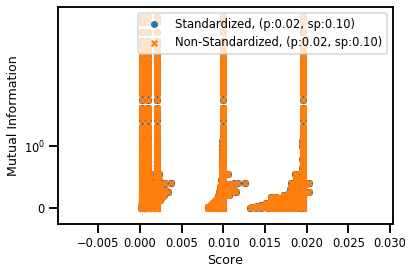

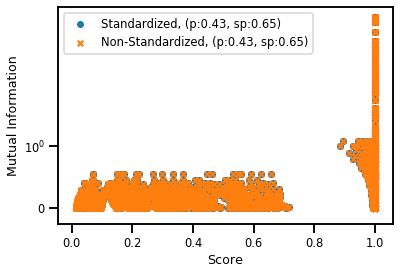

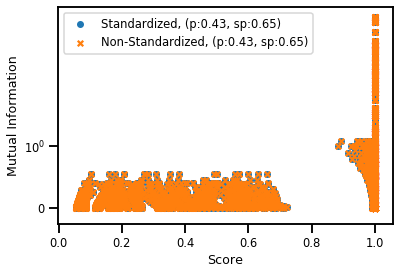

In [315]:
# initialize list of queries
queries = []

# # query dataframe for hsic
# scorers = ['hsic',]
# queries.append(df_query('scorer', scorers))

# query dataframe for scott and silverman methods
sigma_methods = ['scott', 'silverman']
queries.append(df_query('sigma_method', sigma_methods))

sub_df = subset_dataframe(results_df, queries)
    
# plot - score vs mi
plot_score_vs_mi(sub_df,  scorer='hsic', compare='standard');
plot_score_vs_mi(sub_df,  scorer='cka', compare='standard');
plot_score_vs_mi(sub_df,  scorer='ka', compare='standard');

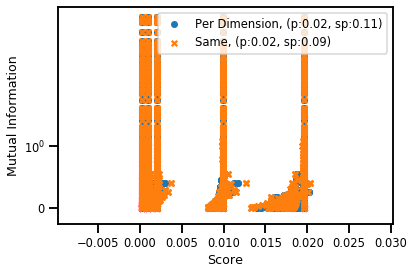

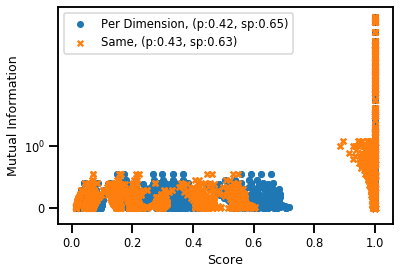

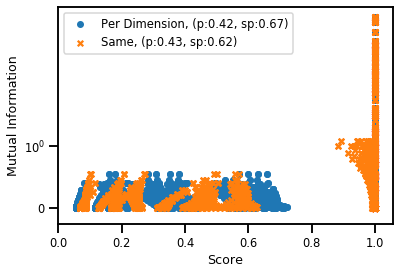

In [316]:
# plot - score vs mi
plot_score_vs_mi(sub_df,  scorer='hsic', compare='dimension');
plot_score_vs_mi(sub_df,  scorer='cka', compare='dimension');
plot_score_vs_mi(sub_df,  scorer='ka', compare='dimension');

## Case II - Median (no percent)

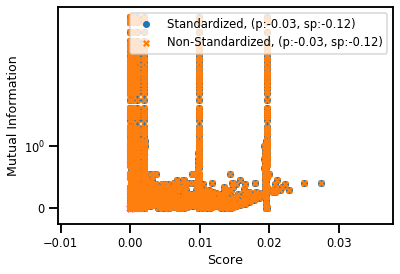

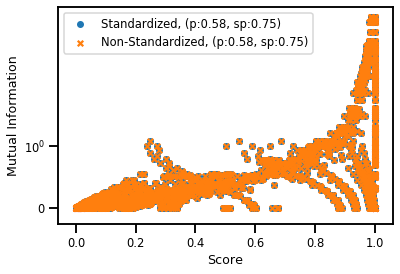

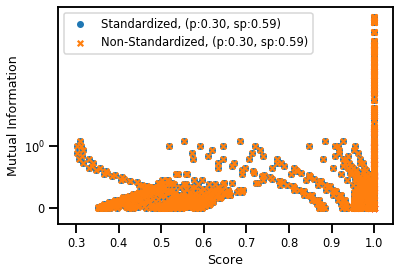

In [317]:
# initialize list of queries
queries = []


# query dataframe for scott and silverman methods
sigma_methods = ['median']
queries.append(df_query('sigma_method', sigma_methods))

# query dataframe for scott and silverman methods
sigma_percents = ['None']
queries.append(df_query('sigma_percent', sigma_percents))

# # query dataframe for hsic
# scorers = ['hsic',]
# queries.append(df_query('scorer', scorers))

sub_df = subset_dataframe(results_df, queries)
    
# plot - score vs mi
plot_score_vs_mi(sub_df,  scorer='hsic', compare='standard');
plot_score_vs_mi(sub_df,  scorer='cka', compare='standard');
plot_score_vs_mi(sub_df,  scorer='ka', compare='standard');

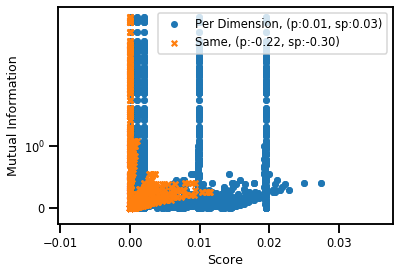

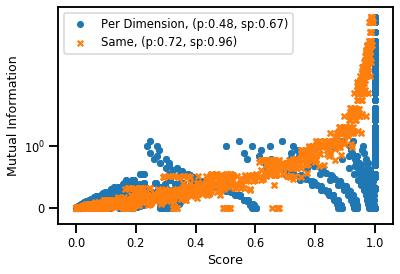

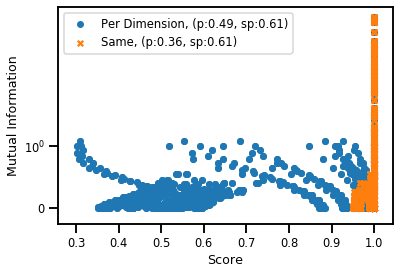

In [318]:
# plot - score vs mi
plot_score_vs_mi(sub_df,  scorer='hsic', compare='dimension');
plot_score_vs_mi(sub_df,  scorer='cka', compare='dimension');
plot_score_vs_mi(sub_df,  scorer='ka', compare='dimension');

## Case III - Median + Percent (50, 20, 60)

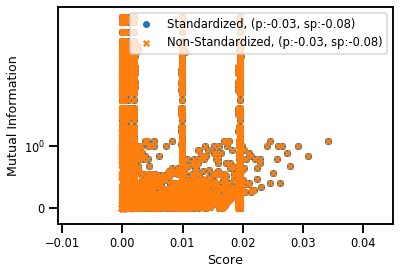

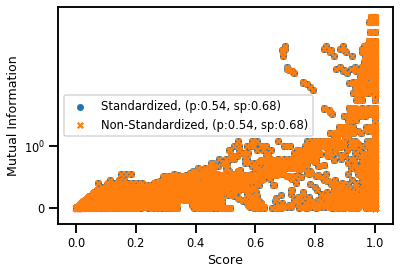

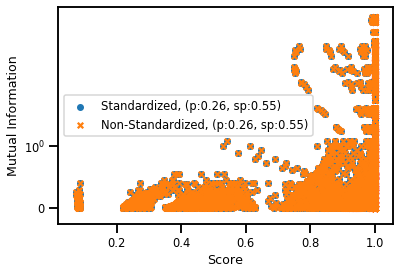

In [319]:
# initialize list of queries
queries = []


# query dataframe for scott and silverman methods
sigma_methods = ['median']
queries.append(df_query('sigma_method', sigma_methods))

# query dataframe for scott and silverman methods
sigma_percents = [20, 50, 80]
queries.append(df_query('sigma_percent', sigma_percents))

# # query dataframe for hsic
# scorers = ['hsic',]
# queries.append(df_query('scorer', scorers))

sub_df = subset_dataframe(results_df, queries)
    
# plot - score vs mi
plot_score_vs_mi(sub_df,  scorer='hsic', compare='standard');
plot_score_vs_mi(sub_df,  scorer='cka', compare='standard');
plot_score_vs_mi(sub_df,  scorer='ka', compare='standard');

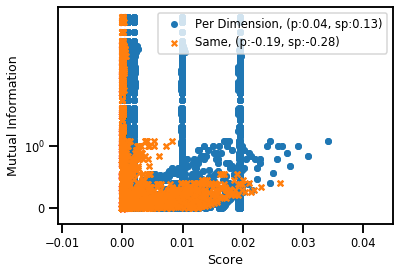

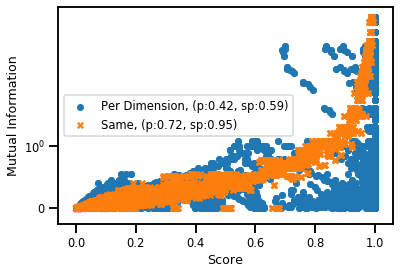

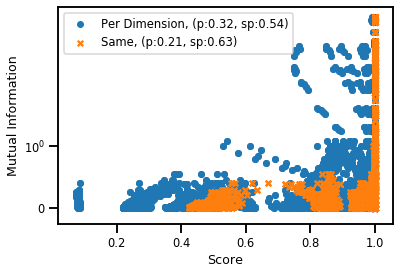

In [320]:
# plot - score vs mi
plot_score_vs_mi(sub_df,  scorer='hsic', compare='dimension');
plot_score_vs_mi(sub_df,  scorer='cka', compare='dimension');
plot_score_vs_mi(sub_df,  scorer='ka', compare='dimension');

## Case IV - Median + Standardization

(24750, 15)


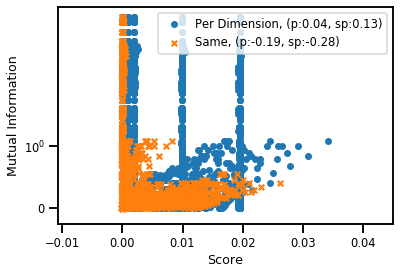

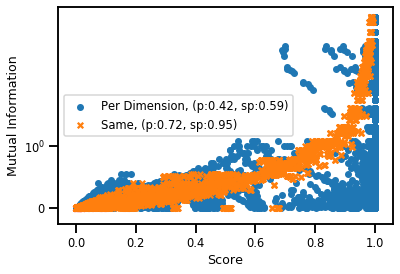

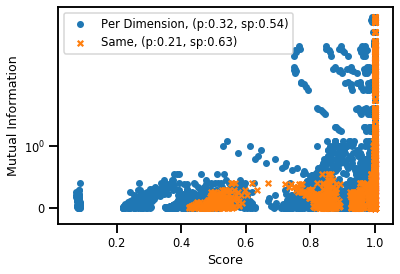

In [321]:
# initialize list of queries
queries = []


# query dataframe for scott and silverman methods
sigma_methods = ['median']
queries.append(df_query('sigma_method', sigma_methods))

# query dataframe for scott and silverman methods
sigma_percents = [20, 50, 80]
queries.append(df_query('sigma_percent', sigma_percents))

# query dataframe for hsic
standardize = [True,]
queries.append(df_query('standardize', standardize))

sub_df = subset_dataframe(results_df, queries)
print(sub_df.shape)
    
# plot - score vs mi
plot_score_vs_mi(sub_df,  scorer='hsic', compare='dimension');
plot_score_vs_mi(sub_df,  scorer='cka', compare='dimension');
plot_score_vs_mi(sub_df,  scorer='ka', compare='dimension');

## Case IV - Median w/o Standardization

(24750, 15)


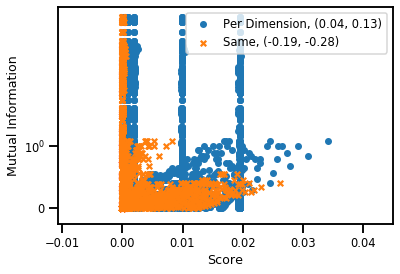

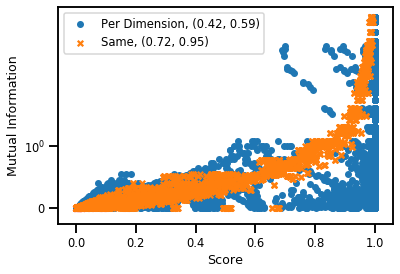

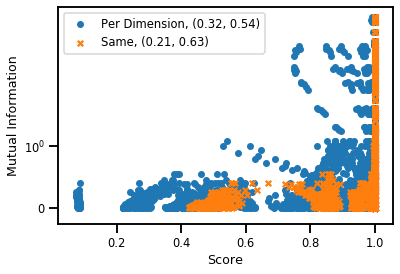

In [310]:
# initialize list of queries
queries = []


# query dataframe for scott and silverman methods
sigma_methods = ['median']
queries.append(df_query('sigma_method', sigma_methods))

# query dataframe for scott and silverman methods
sigma_percents = [20, 50, 80]
queries.append(df_query('sigma_percent', sigma_percents))

# query dataframe for hsic
standardize = [False,]
queries.append(df_query('standardize', standardize))

sub_df = subset_dataframe(results_df, queries)
print(sub_df.shape)
    
# plot - score vs mi
plot_score_vs_mi(sub_df,  scorer='hsic', compare='dimension');
plot_score_vs_mi(sub_df,  scorer='cka', compare='dimension');
plot_score_vs_mi(sub_df,  scorer='ka', compare='dimension');

In [20]:
import time

t0 = time.time()
df_ = pd.concat(results_df, ignore_index=True)
t1 = time.time() - t0
print(f"Time Taken: {t1:.2f} secs")
df_.tail()

Time Taken: 37.71 secs


,dataset,trial,std,nu,samples,dimensions,standardize,per_dimension,separate_scales,sigma_method,sigma_percent,sigma_X,sigma_Y,scorer,score,mutual_info
59395,gauss,5,11,1,50,2,False,False,False,median,0.9,2.88898,2.88898,cka,0.480297,0.390005
59396,gauss,5,11,1,50,3,False,False,False,median,0.9,3.35418,3.35418,cka,0.530064,0.377389
59397,gauss,5,11,1,50,10,False,False,False,median,0.9,5.687,5.687,cka,0.714579,0.929178
59398,gauss,5,11,1,50,50,False,False,False,median,0.9,13.6425,13.6425,cka,0.975977,4.052644
59399,gauss,5,11,1,50,100,False,False,False,median,0.9,19.2544,19.2544,cka,0.987792,7.938746


**Note**: This is another bottleneck.

#### Appending to File

We can use this simple pseudocode to append to a file.

```python
mode = 'a'
header=False
with open(f"{RES_PATH}{save_name}.csv", mode) as f:
    df.to_csv(f, header=header)
    header=True
```